In [74]:
from pyspark.sql import SparkSession

In [75]:
spark=SparkSession.builder.appName("Spark_Models").getOrCreate()

In [76]:
df=spark.read.csv("/Users/hp/spark_data.csv", header=True, inferSchema=True)

In [77]:
df.show(5)

+---------+------+---------+------------------+-----------------+-----------------+-----------------------+-----------------------+-------------------------+--------------------------+--------------------+-----------+--------+------------------+---------------------------------+---------------------+
|workclass|income|age_group|hours-per-week-cat|education-num-cat|occupation_others|occupation_craft_repair|occupation_adm_clerical|occupation_prof_specialty|relationship_not_in_family|relationship_husband|race_others|sex_male|native-country_usa|marital-status_married_civ_spouse|marital-status_others|
+---------+------+---------+------------------+-----------------+-----------------+-----------------------+-----------------------+-------------------------+--------------------------+--------------------+-----------+--------+------------------+---------------------------------+---------------------+
|        0|     1|        0|                 3|                1|                0|           

In [78]:
df.printSchema()

root
 |-- workclass: integer (nullable = true)
 |-- income: integer (nullable = true)
 |-- age_group: integer (nullable = true)
 |-- hours-per-week-cat: integer (nullable = true)
 |-- education-num-cat: integer (nullable = true)
 |-- occupation_others: integer (nullable = true)
 |-- occupation_craft_repair: integer (nullable = true)
 |-- occupation_adm_clerical: integer (nullable = true)
 |-- occupation_prof_specialty: integer (nullable = true)
 |-- relationship_not_in_family: integer (nullable = true)
 |-- relationship_husband: integer (nullable = true)
 |-- race_others: integer (nullable = true)
 |-- sex_male: integer (nullable = true)
 |-- native-country_usa: integer (nullable = true)
 |-- marital-status_married_civ_spouse: integer (nullable = true)
 |-- marital-status_others: integer (nullable = true)



applying scaling

In [79]:
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.sql.functions import col
from pyspark.ml.functions import vector_to_array

In [80]:
assembler=VectorAssembler(inputCols=df.columns, outputCol="features")
df_vector=assembler.transform(df)
scaler=MinMaxScaler(inputCol="features", outputCol="scaled_features")
scaler_model=scaler.fit(df_vector)
df_scaled=scaler_model.transform(df_vector)

df_scaled=df_scaled.withColumn("scaled_features_array", vector_to_array(col("scaled_features")))

for i, col_name in enumerate(df.columns):
    df_scaled=df_scaled.withColumn(col_name, col("scaled_features_array")[i])

df_final=df_scaled.drop("features", "scaled_features", "scaled_features_array")
df_final.show(5)

+---------+------+---------+------------------+------------------+-----------------+-----------------------+-----------------------+-------------------------+--------------------------+--------------------+-----------+--------+------------------+---------------------------------+---------------------+
|workclass|income|age_group|hours-per-week-cat| education-num-cat|occupation_others|occupation_craft_repair|occupation_adm_clerical|occupation_prof_specialty|relationship_not_in_family|relationship_husband|race_others|sex_male|native-country_usa|marital-status_married_civ_spouse|marital-status_others|
+---------+------+---------+------------------+------------------+-----------------+-----------------------+-----------------------+-------------------------+--------------------------+--------------------+-----------+--------+------------------+---------------------------------+---------------------+
|      0.0|   1.0|      0.0|               1.0|0.3333333333333333|              0.0|       

In [81]:
X=df_final.drop("income")
y=df_final.select("income")
assembler=VectorAssembler(inputCols=X.columns, outputCol="features")
df_mllib=assembler.transform(df_final)
df_mllib=df_mllib.select("features", col("income").alias("label"))
df_mllib.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(15,[2,3,7,8,10,1...|  1.0|
|(15,[2,4,8,10,11,...|  0.0|
|(15,[7,9,10,12,13...|  0.0|
|(15,[9,12],[1.0,1...|  0.0|
|(15,[3,4,10,11,12...|  0.0|
+--------------------+-----+
only showing top 5 rows



In [82]:
train_df, test_df=df_mllib.randomSplit([0.8, 0.2], seed=42)

print(f"Training Set: {train_df.count()} rows")
print(f"Test Set: {test_df.count()} rows")

train_df.show(5, truncate=False)
test_df.show(5, truncate=False)


Training Set: 37055 rows
Test Set: 9279 rows
+----------------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                              |label|
+----------------------------------------------------------------------------------------------------------------------+-----+
|(15,[],[])                                                                                                            |0.0  |
|(15,[],[])                                                                                                            |0.0  |
|(15,[0],[0.7142857142857142])                                                                                         |0.0  |
|(15,[0,1,2,3,4,8,11,13],[0.2857142857142857,0.6666666666666666,0.3333333333333333,0.3333333333333333,1.0,1.0,1.0,1.0])|0.0  |
|(15,[0,1,2,3,4,9,10],[0.14285714285714285,0.6666666666666666,1.0,

<span style="color:salmon; font-size:20px;">1. K Means</span>

In [83]:
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt

In [84]:
inertia=[]
values=range(2, 20)

for k in values:
    kmeans=KMeans(featuresCol="features", k=k, seed=42)
    model=kmeans.fit(df_mllib)
    cost=model.summary.trainingCost
    inertia.append(cost)

finding value of k

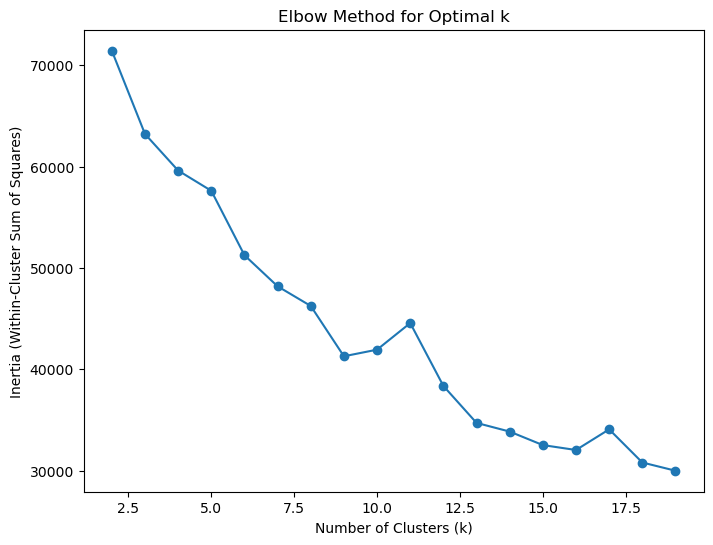

In [85]:
plt.figure(figsize=(8, 6))
plt.plot(values, inertia, marker="o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for Optimal k")
plt.show()

In [86]:
optimal_k = 5

kmeans = KMeans(featuresCol="features", k=optimal_k, seed=42)
final_model = kmeans.fit(df_mllib)

predictions = final_model.transform(df_mllib)
predictions.select("features", "prediction").show(5, truncate=False)

+---------------------------------------------------------------------------+----------+
|features                                                                   |prediction|
+---------------------------------------------------------------------------+----------+
|(15,[2,3,7,8,10,11,12,13],[1.0,0.3333333333333333,1.0,1.0,1.0,1.0,1.0,1.0])|0         |
|(15,[2,4,8,10,11,13],[0.3333333333333333,1.0,1.0,1.0,1.0,1.0])             |0         |
|(15,[7,9,10,12,13],[1.0,1.0,1.0,1.0,1.0])                                  |2         |
|(15,[9,12],[1.0,1.0])                                                      |1         |
|(15,[3,4,10,11,12,14],[0.3333333333333333,1.0,1.0,1.0,1.0,1.0])            |3         |
+---------------------------------------------------------------------------+----------+
only showing top 5 rows



In [87]:
print("cluster centers:")
for center in final_model.clusterCenters():
    print(center)


cluster centers:
[0.11055901 0.2        0.18532832 0.19978529 0.42329576 0.22678476
 0.13628556 0.16553945 0.99935588 0.         0.91030596 0.99994632
 0.91975309 0.99946323 0.        ]
[0.100824   0.21244329 0.15268957 0.15722618 0.         0.16215165
 0.19624109 0.22981205 0.         0.47362281 0.82410888 0.09526896
 0.93648736 0.         0.49799093]
[1.23202744e-01 1.44352108e-01 1.54662973e-01 1.90674054e-01
 9.23361034e-04 1.30193906e-01 4.50600185e-01 1.64819945e-01
 0.00000000e+00 9.98153278e-01 8.44413666e-01 7.52539243e-02
 9.13665743e-01 7.62696214e-01 0.00000000e+00]
[0.06019861 0.18799734 0.16721001 0.19525362 0.48427805 0.28215375
 0.0847618  0.06320328 0.         0.52560732 0.85077295 1.
 0.91397623 0.         0.88684404]
[0.04984707 0.21044824 0.16426109 0.19854061 1.         0.
 0.         0.         0.         0.60175607 0.79516478 0.21541977
 0.90209286 0.10476305 0.37274477]


visualisations

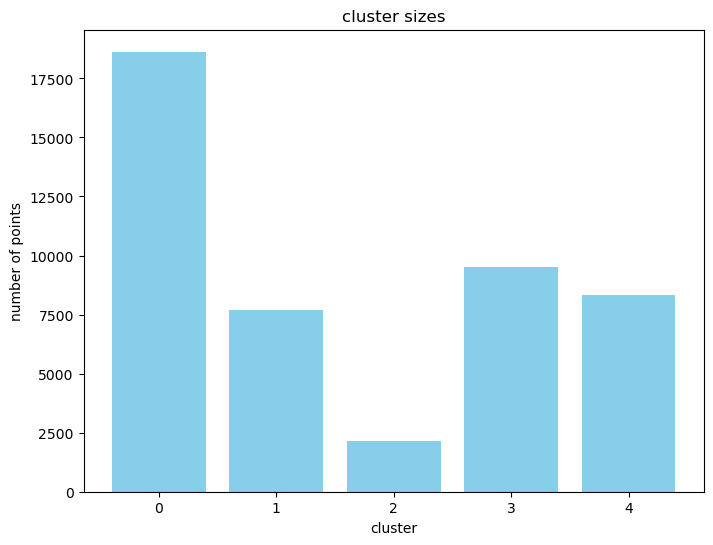

In [88]:
cluster_sizes = predictions.groupBy("prediction").count().toPandas()

plt.figure(figsize=(8, 6))
plt.bar(cluster_sizes["prediction"], cluster_sizes["count"], color="skyblue")
plt.xlabel("cluster")
plt.ylabel("number of points")
plt.title("cluster sizes")
plt.show()

In [89]:
from pyspark.ml.evaluation import ClusteringEvaluator

In [90]:
silhouette_scores=[]
values=range(2, 10)

for k in values:
    kmeans=KMeans(featuresCol="features", k=k, seed=42)
    model=kmeans.fit(df_mllib)
    predictions=model.transform(df_mllib)

    evaluator=ClusteringEvaluator(featuresCol="features", predictionCol="prediction", metricName="silhouette")
    silhouette_scores.append(evaluator.evaluate(predictions))

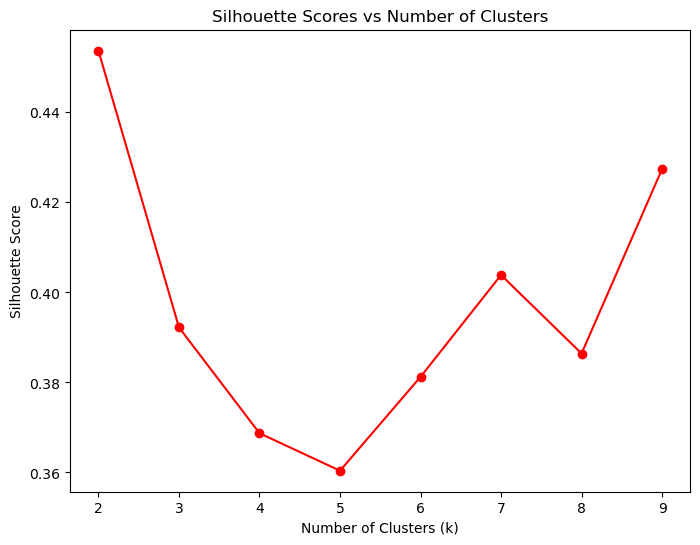

In [91]:
plt.figure(figsize=(8, 6))
plt.plot(values, silhouette_scores, marker="o", color="red")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores vs Number of Clusters")
plt.show()

In [92]:
import seaborn as sns
import pandas as pd

In [93]:
feature_columns=[col for col in df_final.columns if col != "income"]

if len(feature_columns)!=len(final_model.clusterCenters()[0]):
    
    feature_columns=[f"feature_{i}" for i in range(len(final_model.clusterCenters()[0]))]

cluster_centers=final_model.clusterCenters()
cluster_centers_df=pd.DataFrame(cluster_centers, columns=feature_columns)

heatmap

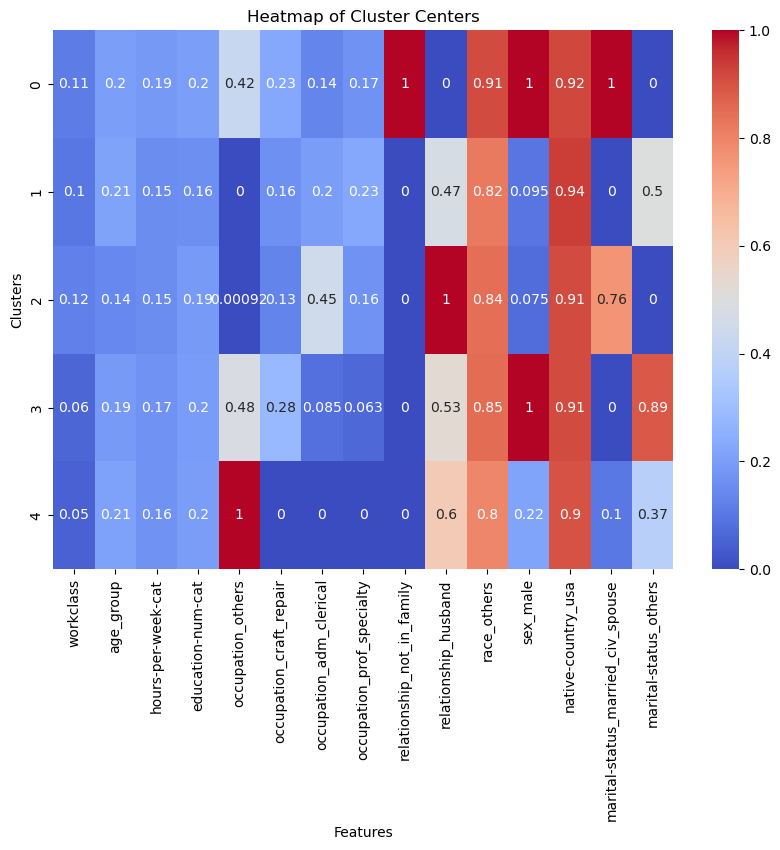

In [94]:
plt.figure(figsize=(10, 7))
sns.heatmap(cluster_centers_df, annot=True, cmap="coolwarm")
plt.title("Heatmap of Cluster Centers")
plt.xlabel("Features")
plt.ylabel("Clusters")
plt.show()

PCA to visualise clusters

In [95]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.sql import Row
import matplotlib.pyplot as plt

In [96]:
pca=PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model=pca.fit(predictions)
pca_result=pca_model.transform(predictions)

pca_df=pca_result.select("pca_features", "prediction").toPandas()

pca_df["pca1"]=pca_df["pca_features"].apply(lambda x: x[0])
pca_df["pca2"]=pca_df["pca_features"].apply(lambda x: x[1])

In [97]:
cluster_centers=final_model.clusterCenters()

cluster_centers_vectors=[Row(features=Vectors.dense(center)) for center in cluster_centers]
cluster_centers_df=spark.createDataFrame(cluster_centers_vectors)

cluster_centers_pca=pca_model.transform(cluster_centers_df).toPandas()
cluster_centers_pca["pca1"]=cluster_centers_pca["pca_features"].apply(lambda x: x[0])
cluster_centers_pca["pca2"]=cluster_centers_pca["pca_features"].apply(lambda x: x[1])

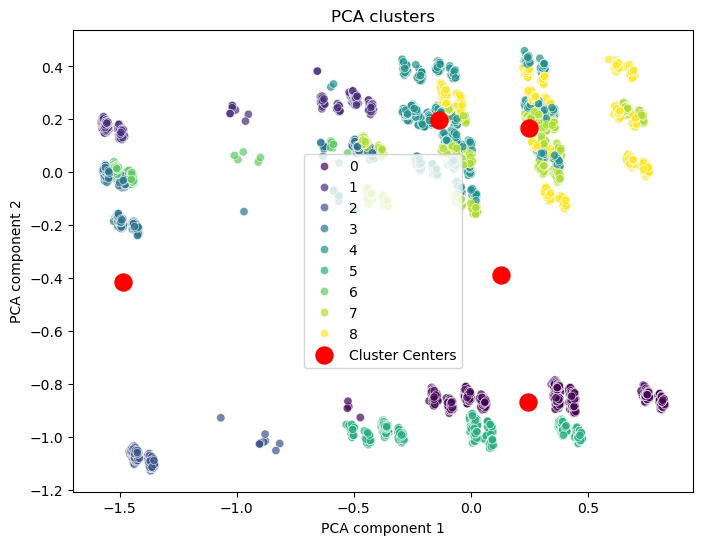

In [98]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="pca1", y="pca2", hue="prediction", palette="viridis", alpha=0.7, legend="full")
plt.scatter(cluster_centers_pca["pca1"], cluster_centers_pca["pca2"], color="red", marker="o", s=150, label="Cluster Centers")
plt.xlabel("PCA component 1")
plt.ylabel("PCA component 2")
plt.title("PCA clusters")
plt.legend(loc="best")
plt.show()

<span style="color:salmon; font-size:20px;">2. K Naive Bayes</span>

In [99]:
from pyspark.ml.classification import NaiveBayes

In [100]:
nb=NaiveBayes(featuresCol="features", labelCol="label", modelType="multinomial")
nb_model=nb.fit(train_df)
naive_bayes_predictions=nb_model.transform(test_df)
naive_bayes_predictions.select("label", "prediction", "probability").show(5, truncate=False)

+-----+----------+-----------------------------------------+
|label|prediction|probability                              |
+-----+----------+-----------------------------------------+
|0.0  |0.0       |[0.7598294519254121,0.24017054807458788] |
|0.0  |0.0       |[0.9593845929075849,0.04061540709241514] |
|0.0  |0.0       |[0.9430546178371209,0.056945382162879234]|
|0.0  |0.0       |[0.967530953143787,0.03246904685621298]  |
|0.0  |0.0       |[0.8774259045471614,0.12257409545283857] |
+-----+----------+-----------------------------------------+
only showing top 5 rows



In [101]:
from pyspark.sql.types import DoubleType

nb_eval_predictions=naive_bayes_predictions.withColumn("label", col("label").cast(DoubleType())).withColumn("prediction", col("prediction").cast(DoubleType()))

In [102]:
nb_predictions_rdd=nb_eval_predictions.select("label", "prediction").rdd.map(lambda row: (row[0], row[1]))

In [103]:
from pyspark.mllib.evaluation import MulticlassMetrics

nb_metrics=MulticlassMetrics(nb_predictions_rdd)

confusion_matrix=nb_metrics.confusionMatrix().toArray()
print("confusion matrix:")
print(confusion_matrix)
accuracy=nb_metrics.accuracy
print(f"accuracy: {accuracy:.2f}")

/opt/anaconda3/lib/python3.9/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


confusion matrix:
[[6396. 1243.]
 [ 663.  977.]]
accuracy: 0.79


confusion matrix

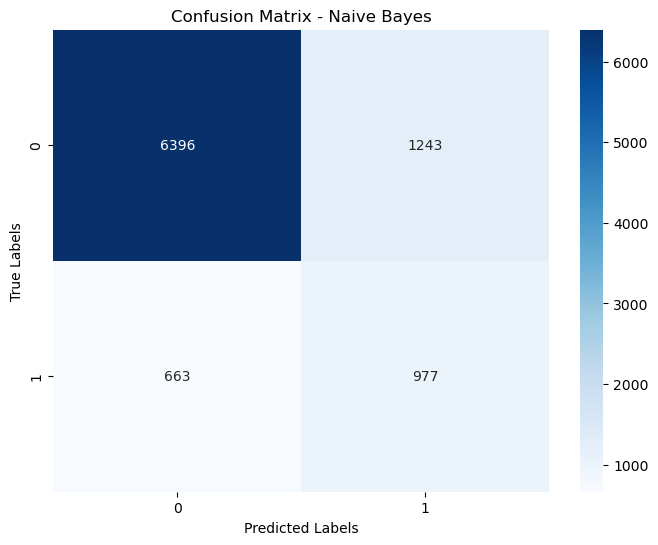

In [104]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt=".0f", cmap="Blues", xticklabels=True, yticklabels=True)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Naive Bayes")
plt.show()

In [105]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator=BinaryClassificationEvaluator(rawPredictionCol="probability", labelCol="label", metricName="areaUnderROC")
roc_auc=evaluator.evaluate(naive_bayes_predictions)
print(f"ROC AUC: {roc_auc:.2f}")

ROC AUC: 0.82


In [106]:
from pyspark.sql.functions import udf
from pyspark.ml.linalg import DenseVector

In [107]:
def extract_dense_vector(vector):
    return DenseVector(vector.toArray())

extract_dense_udf=udf(lambda x: extract_dense_vector(x).values.tolist(), "array<double>")
naive_bayes_predictions2=naive_bayes_predictions.withColumn("dense_probability", extract_dense_udf(col("probability")))
naive_bayes_predictions2=naive_bayes_predictions2.withColumn("prob_positive", col("dense_probability")[1])
nb_pd=naive_bayes_predictions2.select("label", "prob_positive").toPandas()

y_true=nb_pd["label"]
y_scores=nb_pd["prob_positive"]

ROC curve

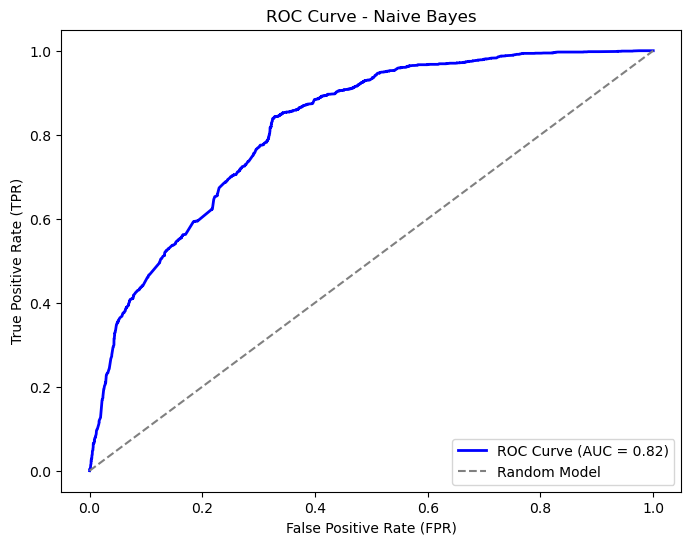

In [108]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds=roc_curve(y_true, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Model")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve - Naive Bayes")
plt.legend(loc="lower right")
plt.show()

precison recall curve

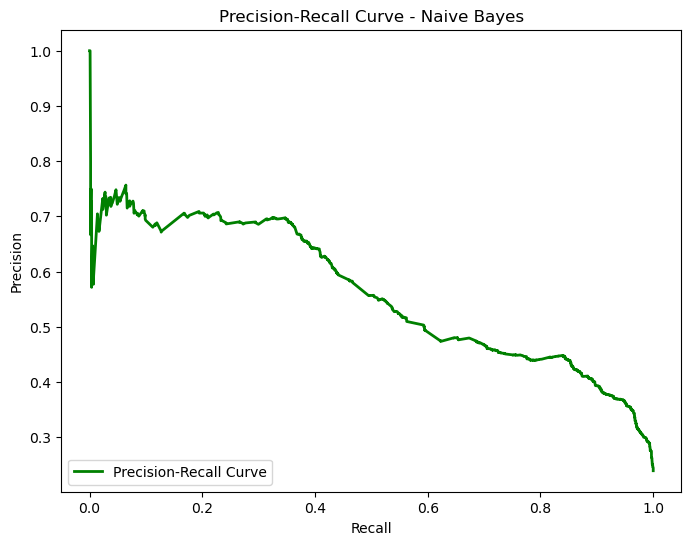

In [109]:
from sklearn.metrics import precision_recall_curve

precision, recall, _=precision_recall_curve(y_true, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color="green", lw=2, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Naive Bayes")
plt.legend(loc="lower left")
plt.show()


<span style="color:salmon; font-size:20px;">3. Random Forest Classifier</span>

In [110]:
from pyspark.ml.classification import RandomForestClassifier

rf=RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100, maxDepth=5, seed=42)
rf_model=rf.fit(train_df)

rf_predictions=rf_model.transform(test_df)
rf_predictions.select("label", "prediction", "probability").show(5, truncate=False)

+-----+----------+----------------------------------------+
|label|prediction|probability                             |
+-----+----------+----------------------------------------+
|0.0  |0.0       |[0.9146096254046244,0.08539037459537561]|
|0.0  |0.0       |[0.9180755459513646,0.08192445404863533]|
|0.0  |0.0       |[0.9008711112789284,0.09912888872107155]|
|0.0  |0.0       |[0.9180755459513646,0.08192445404863533]|
|0.0  |0.0       |[0.9144261284305231,0.08557387156947695]|
+-----+----------+----------------------------------------+
only showing top 5 rows



In [111]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator=MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

accuracy=evaluator.evaluate(rf_predictions)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.82


In [112]:
rf_eval_predictions=rf_predictions.withColumn("label", col("label").cast(DoubleType())).withColumn("prediction", col("prediction").cast(DoubleType()))
rf_predictions_rdd=rf_eval_predictions.select("label", "prediction").rdd.map(tuple)
rf_metrics=MulticlassMetrics(rf_predictions_rdd)
confusion_matrix=rf_metrics.confusionMatrix().toArray()
print("confusion matrix:")
print(confusion_matrix)

/opt/anaconda3/lib/python3.9/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


confusion matrix:
[[6698. 1327.]
 [ 361.  893.]]


confusion matrix

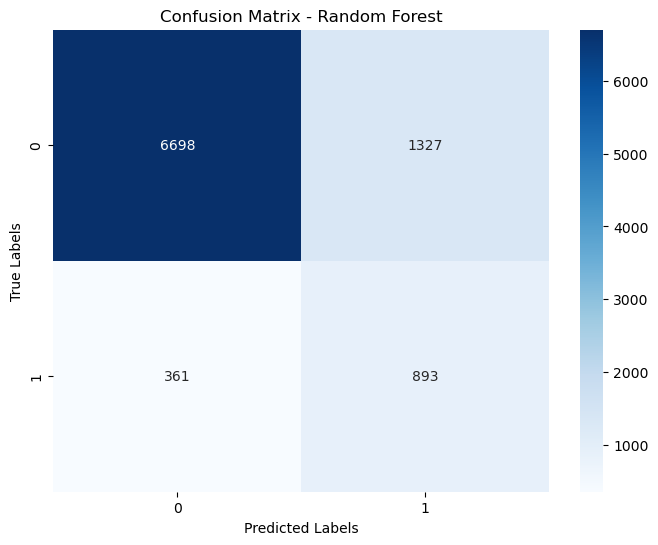

In [113]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt=".0f", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Random Forest")
plt.show()

feature importance

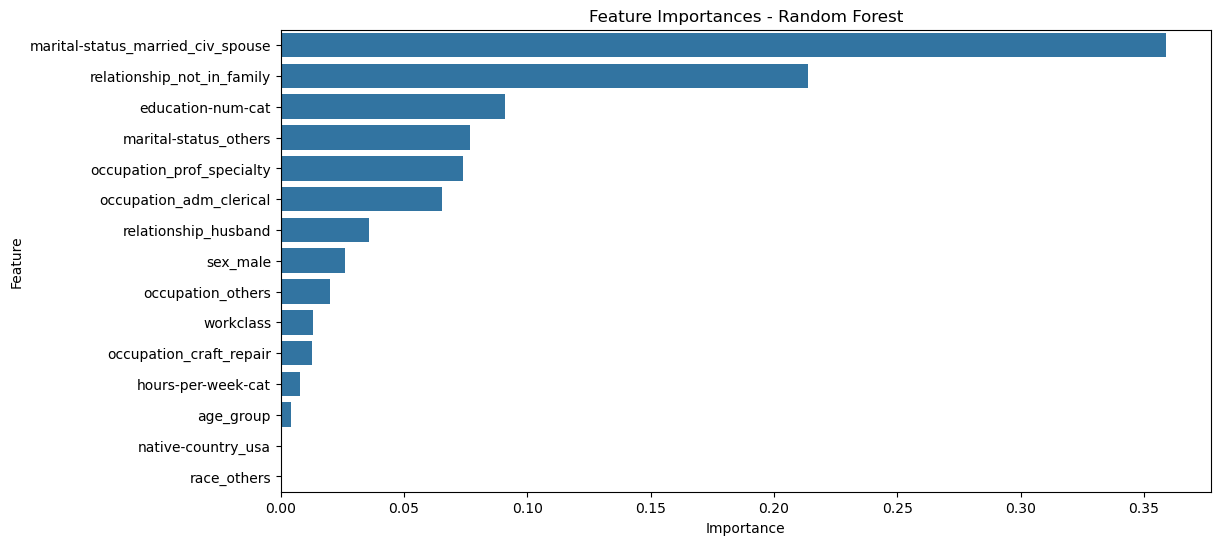

In [114]:
feature_importances=rf_model.featureImportances.toArray()
feature_names=train_df.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]
feature_names=[attr["name"] for attr in feature_names]
feature_importance_df=pd.DataFrame({"Feature": feature_names, "Importance": feature_importances})
feature_importance_df=feature_importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df)
plt.title("Feature Importances - Random Forest")
plt.show()

In [115]:
def sparse_to_dense(sparse_vec):
    return DenseVector(sparse_vec.toArray())

sparse_to_dense_udf=udf(lambda x: sparse_to_dense(x).values.tolist(), "array<double>")

rf_predictions=rf_predictions.withColumn("dense_probability", sparse_to_dense_udf(col("probability")))
rf_predictions=rf_predictions.withColumn("prob_positive", col("dense_probability")[1])

rf_pd=rf_predictions.select("label", "prob_positive").toPandas()


ROC curve

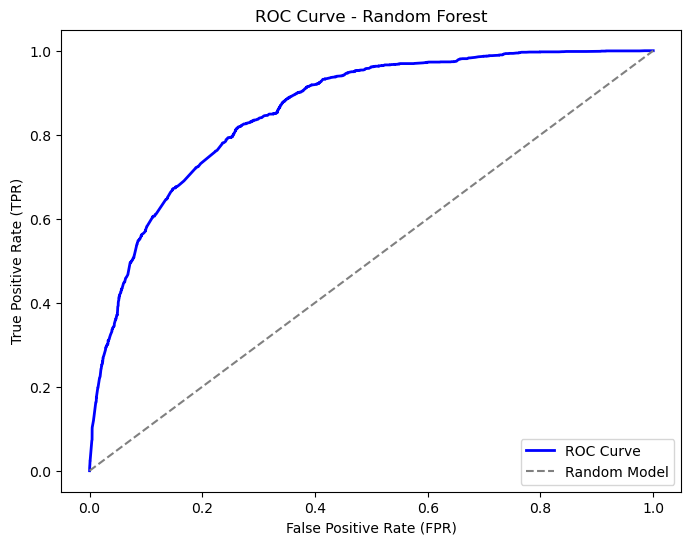

In [116]:
fpr, tpr, thresholds=roc_curve(rf_pd["label"], rf_pd["prob_positive"])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Model")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve - Random Forest")
plt.legend(loc="lower right")
plt.show()

precison recall curve

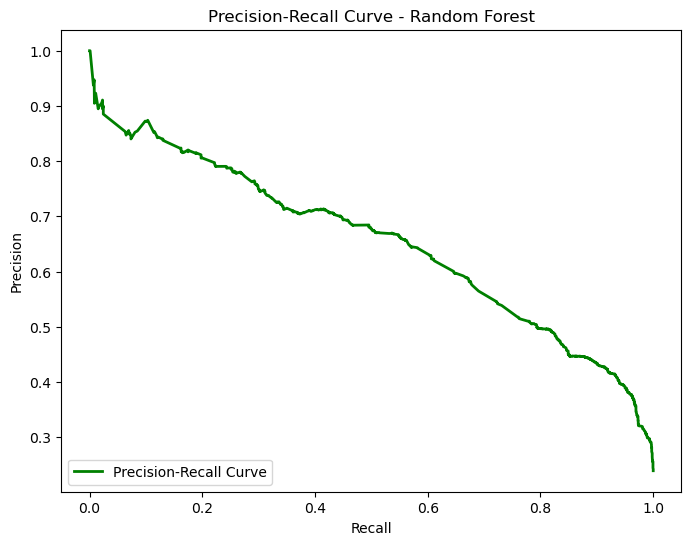

In [117]:
y_true=rf_pd["label"]
y_scores=rf_pd["prob_positive"]

precision, recall, thresholds=precision_recall_curve(y_true, y_scores)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color="green", lw=2, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Random Forest")
plt.legend(loc="lower left")
plt.show()

<span style="color:salmon; font-size:20px;">4. Gradient Boosting Classifier</span>

In [118]:
from pyspark.ml.classification import GBTClassifier

gbt=GBTClassifier(featuresCol="features", labelCol="label", maxIter=50, maxDepth=5, seed=42)
gbt_model=gbt.fit(train_df)

gbt_predictions=gbt_model.transform(test_df)
gbt_predictions.select("label", "prediction", "probability").show(5, truncate=False)

+-----+----------+----------------------------------------+
|label|prediction|probability                             |
+-----+----------+----------------------------------------+
|0.0  |0.0       |[0.9607846581503559,0.03921534184964415]|
|0.0  |0.0       |[0.9418790933128528,0.0581209066871472] |
|0.0  |1.0       |[0.4593164740638001,0.5406835259362]    |
|0.0  |0.0       |[0.963547863054608,0.036452136945391955]|
|0.0  |0.0       |[0.9207835573844643,0.07921644261553573]|
+-----+----------+----------------------------------------+
only showing top 5 rows



In [119]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

accuracy = evaluator.evaluate(gbt_predictions)
print(f"accuracy: {accuracy:.2f}")

accuracy: 0.83


In [120]:
gbt_eval_predictions=gbt_predictions.withColumn("label", col("label").cast(DoubleType())).withColumn("prediction", col("prediction").cast(DoubleType()))

gbt_predictions_rdd=gbt_eval_predictions.select("label", "prediction").rdd.map(tuple)

gbt_metrics=MulticlassMetrics(gbt_predictions_rdd)

confusion_matrix=gbt_metrics.confusionMatrix().toArray()
print("confusion matrix:")
print(confusion_matrix)

/opt/anaconda3/lib/python3.9/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


confusion matrix:
[[6520. 1010.]
 [ 539. 1210.]]


confusion matrix

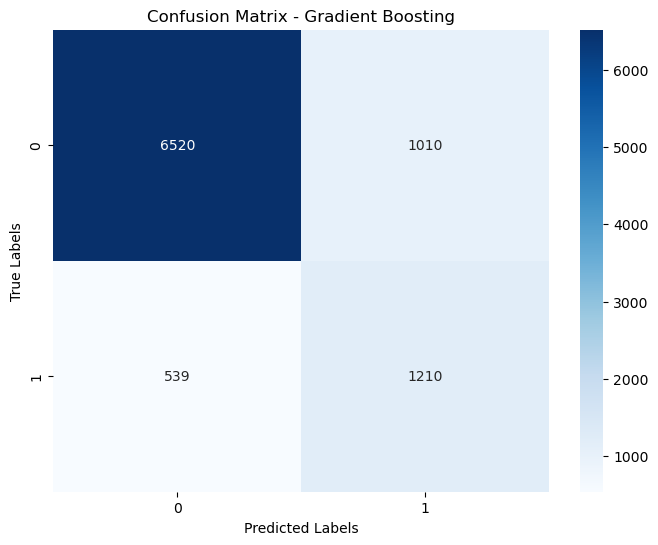

In [121]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt=".0f", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Gradient Boosting")
plt.show()

feature importances

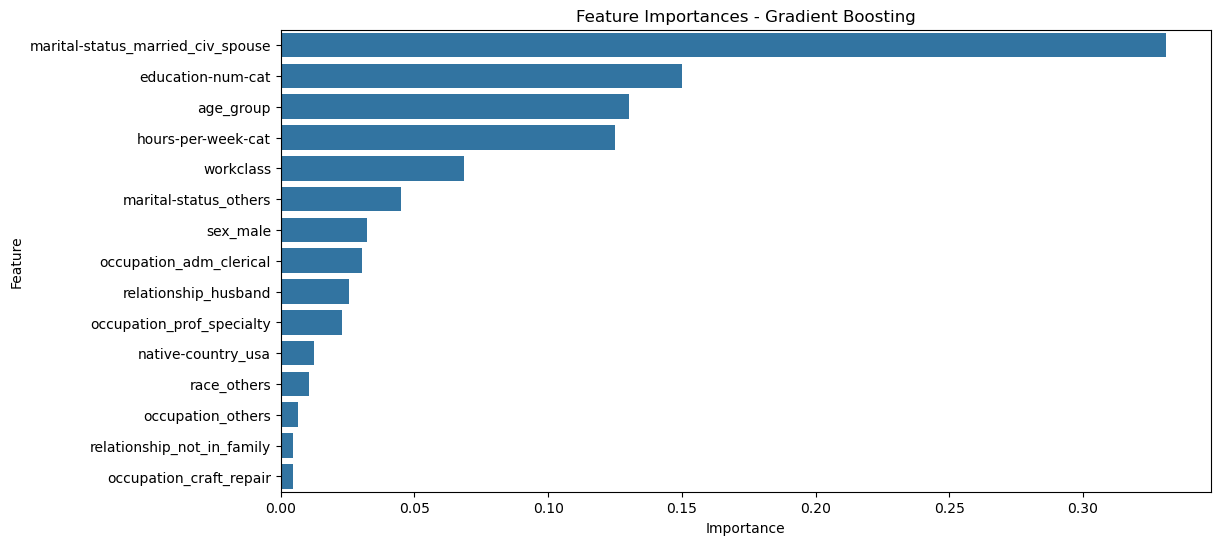

In [122]:
feature_importances=gbt_model.featureImportances.toArray()

feature_names=train_df.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]
feature_names=[attr["name"] for attr in feature_names]
feature_importance_df=pd.DataFrame({"Feature": feature_names, "Importance": feature_importances})
feature_importance_df=feature_importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df)
plt.title("Feature Importances - Gradient Boosting")
plt.show()

In [123]:
evaluator_auc=BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="probability", metricName="areaUnderROC")
roc_auc=evaluator_auc.evaluate(gbt_predictions)
print(f"ROC AUC: {roc_auc:.2f}")

ROC AUC: 0.88


In [124]:
def sparse_to_dense(sparse_vec):
    return DenseVector(sparse_vec.toArray())

sparse_to_dense_udf=udf(lambda x: sparse_to_dense(x).values.tolist(), "array<double>")
gbt_predictions=gbt_predictions.withColumn("dense_probability", sparse_to_dense_udf(col("probability")))
gbt_predictions=gbt_predictions.withColumn("prob_positive", col("dense_probability")[1])
gbt_predictions.select("label", "prediction", "prob_positive").show(5, truncate=False)

+-----+----------+--------------------+
|label|prediction|prob_positive       |
+-----+----------+--------------------+
|0.0  |0.0       |0.03921534184964415 |
|0.0  |0.0       |0.0581209066871472  |
|0.0  |1.0       |0.5406835259362     |
|0.0  |0.0       |0.036452136945391955|
|0.0  |0.0       |0.07921644261553573 |
+-----+----------+--------------------+
only showing top 5 rows



roc curve

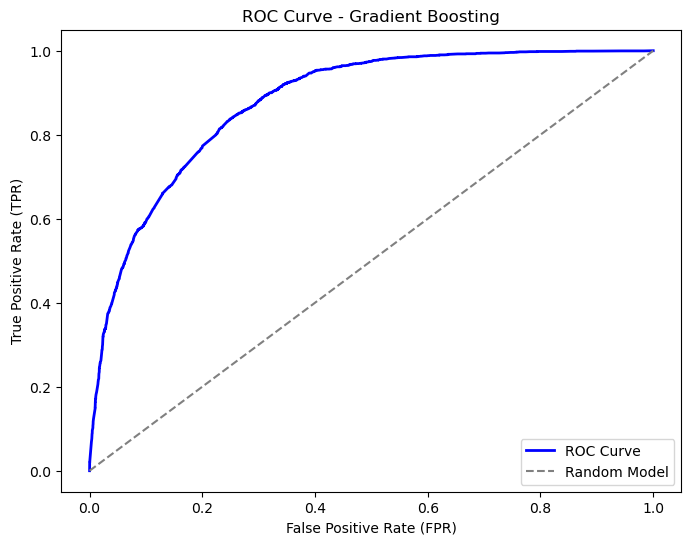

In [125]:
gbt_pd=gbt_predictions.select("label", "prob_positive").toPandas()
y_true=gbt_pd["label"]
y_scores=gbt_pd["prob_positive"]

fpr, tpr, _=roc_curve(y_true, y_scores)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label="ROC Curve")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Model")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve - Gradient Boosting")
plt.legend(loc="lower right")
plt.show()

preciion recall curve

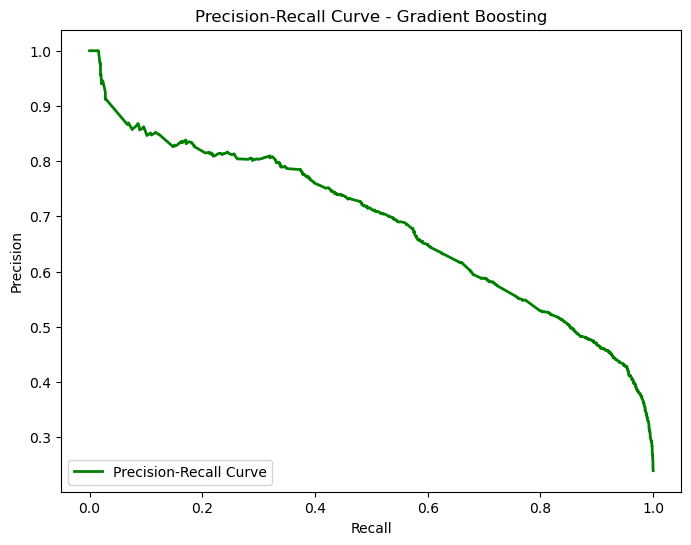

In [126]:
precision, recall, _=precision_recall_curve(y_true, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color="green", lw=2, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Gradient Boosting")
plt.legend(loc="lower left")
plt.show()

<span style="color:salmon; font-size:20px;">5. Logistic Regression</span>

In [127]:
from pyspark.ml.classification import LogisticRegression

lr=LogisticRegression(featuresCol="features", labelCol="label", maxIter=50, regParam=0.01)
lr_model=lr.fit(train_df)

lr_predictions=lr_model.transform(test_df)
lr_predictions.select("label", "prediction", "probability").show(5, truncate=False)

+-----+----------+-----------------------------------------+
|label|prediction|probability                              |
+-----+----------+-----------------------------------------+
|0.0  |0.0       |[0.9381986006385886,0.06180139936141138] |
|0.0  |0.0       |[0.9576447343114183,0.04235526568858172] |
|0.0  |0.0       |[0.9145740344750313,0.08542596552496873] |
|0.0  |0.0       |[0.9495033076447543,0.050496692355245676]|
|0.0  |0.0       |[0.9429898143737393,0.0570101856262607]  |
+-----+----------+-----------------------------------------+
only showing top 5 rows



In [128]:
evaluator=MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy=evaluator.evaluate(lr_predictions)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.82


confusion matrix

In [129]:
lr_eval_predictions=lr_predictions.withColumn("label", col("label").cast(DoubleType())).withColumn("prediction", col("prediction").cast(DoubleType()))
lr_predictions_rdd=lr_eval_predictions.select("label", "prediction").rdd.map(tuple)
lr_metrics=MulticlassMetrics(lr_predictions_rdd)
confusion_matrix=lr_metrics.confusionMatrix().toArray()
print("confusion matrix:")
print(confusion_matrix)

/opt/anaconda3/lib/python3.9/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


confusion matrix:
[[6667. 1310.]
 [ 392.  910.]]


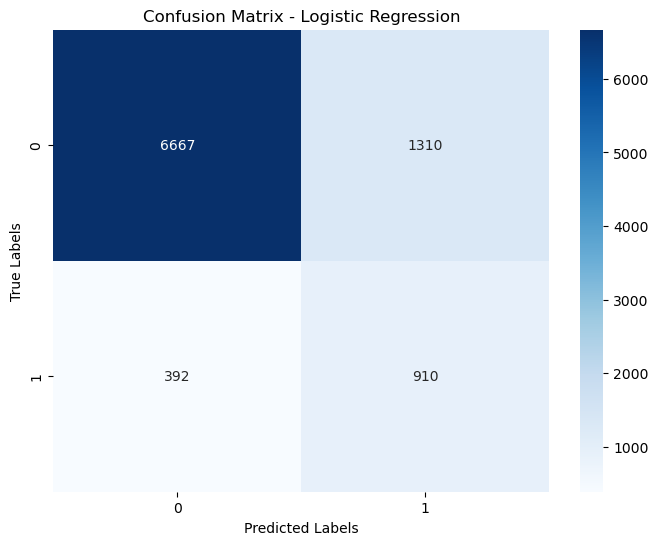

In [130]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt=".0f", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

In [131]:
evaluator_auc=BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="probability", metricName="areaUnderROC")
roc_auc=evaluator_auc.evaluate(lr_predictions)
print(f"ROC AUC: {roc_auc:.2f}")

ROC AUC: 0.84


In [132]:
from pyspark.sql.types import ArrayType

def sparse_to_dense(sparse_vec):
    return DenseVector(sparse_vec.toArray())

sparse_to_dense_udf=udf(lambda x: sparse_to_dense(x).values.tolist(), ArrayType(DoubleType()))
lr_predictions=lr_predictions.withColumn("dense_probability", sparse_to_dense_udf(col("probability")))
lr_predictions=lr_predictions.withColumn("prob_positive", col("dense_probability")[1])
lr_predictions.select("label", "prediction", "prob_positive").show(5, truncate=False)

+-----+----------+--------------------+
|label|prediction|prob_positive       |
+-----+----------+--------------------+
|0.0  |0.0       |0.06180139936141138 |
|0.0  |0.0       |0.04235526568858172 |
|0.0  |0.0       |0.08542596552496873 |
|0.0  |0.0       |0.050496692355245676|
|0.0  |0.0       |0.0570101856262607  |
+-----+----------+--------------------+
only showing top 5 rows



ROC curve

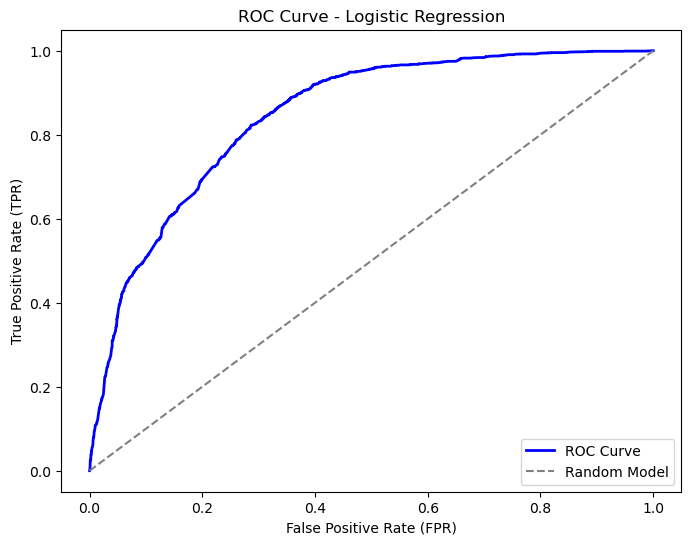

In [133]:
lr_pd=lr_predictions.select("label", "prob_positive").toPandas()
y_true=lr_pd["label"]
y_scores=lr_pd["prob_positive"]

fpr, tpr, thresholds=roc_curve(y_true, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label="ROC Curve")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Model")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc="lower right")
plt.show()

precison recall curve

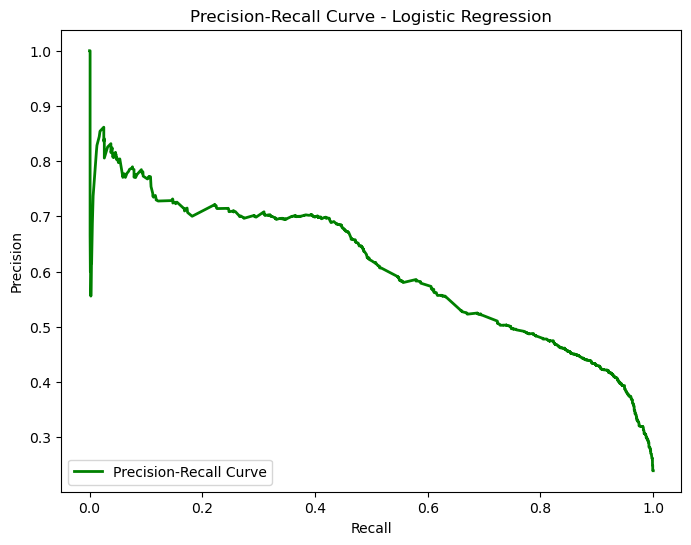

In [134]:
precision, recall, thresholds=precision_recall_curve(y_true, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color="green", lw=2, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Logistic Regression")
plt.legend(loc="lower left")
plt.show()

In [135]:
coefficients=lr_model.coefficients.toArray()
feature_names=train_df.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]
feature_names=[attr["name"] for attr in feature_names]
coefficients_df=pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})
coefficients_df["abs_coefficient"]=coefficients_df["Coefficient"].abs()
coefficients_df=coefficients_df.sort_values(by="abs_coefficient", ascending=False)
coefficients_df=coefficients_df.drop("abs_coefficient", axis=1)

feature importances

/var/folders/cj/0kgtzv813nq7ln3yhf7ms5n40000gn/T/ipykernel_43619/3182118271.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coefficients_df, x="Coefficient", y="Feature", palette="viridis")


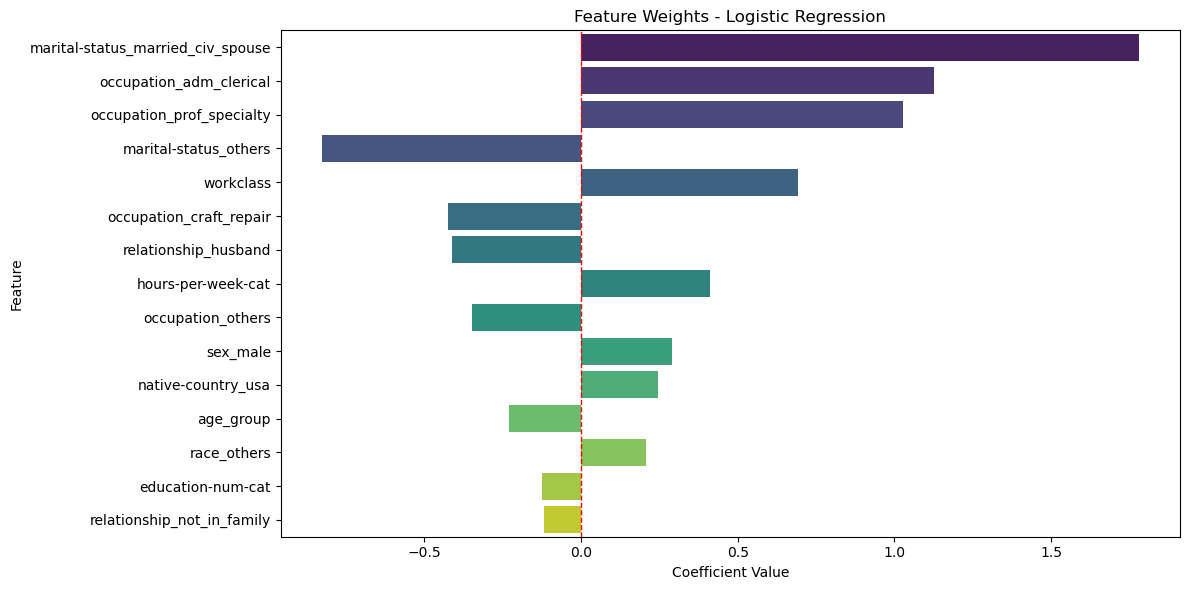

In [136]:
plt.figure(figsize=(12, 6))
sns.barplot(data=coefficients_df, x="Coefficient", y="Feature", palette="viridis")
plt.title("Feature Weights - Logistic Regression")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.axvline(0, color="red", linestyle="--", linewidth=1)
plt.tight_layout()
plt.show()

<span style="color:salmon; font-size:20px;">6. SVM</span>

In [137]:
from pyspark.ml.classification import LinearSVC

svm=LinearSVC(featuresCol="features", labelCol="label", maxIter=100, regParam=0.01)
svm_model=svm.fit(train_df)

svm_predictions=svm_model.transform(test_df)
svm_predictions.select("label", "prediction", "rawPrediction").show(5, truncate=False)

+-----+----------+----------------------------------------+
|label|prediction|rawPrediction                           |
+-----+----------+----------------------------------------+
|0.0  |0.0       |[2.223804387100158,-2.223804387100158]  |
|0.0  |0.0       |[2.883525719388934,-2.883525719388934]  |
|0.0  |0.0       |[2.7494602836135504,-2.7494602836135504]|
|0.0  |0.0       |[2.8834564320560947,-2.8834564320560947]|
|0.0  |0.0       |[2.989383022203835,-2.989383022203835]  |
+-----+----------+----------------------------------------+
only showing top 5 rows



In [138]:
evaluator=MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

accuracy=evaluator.evaluate(svm_predictions)
print(f"accuracy: {accuracy:.2f}")

accuracy: 0.82


In [139]:
svm_eval_predictions=svm_predictions.withColumn("label", col("label").cast(DoubleType())).withColumn("prediction", col("prediction").cast(DoubleType()))

svm_predictions_rdd=svm_eval_predictions.select("label", "prediction").rdd.map(tuple)

svm_metrics=MulticlassMetrics(svm_predictions_rdd)

confusion_matrix=svm_metrics.confusionMatrix().toArray()
print("confusion matrix:")
print(confusion_matrix)

/opt/anaconda3/lib/python3.9/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


confusion matrix:
[[6676. 1320.]
 [ 383.  900.]]


confusion matrix

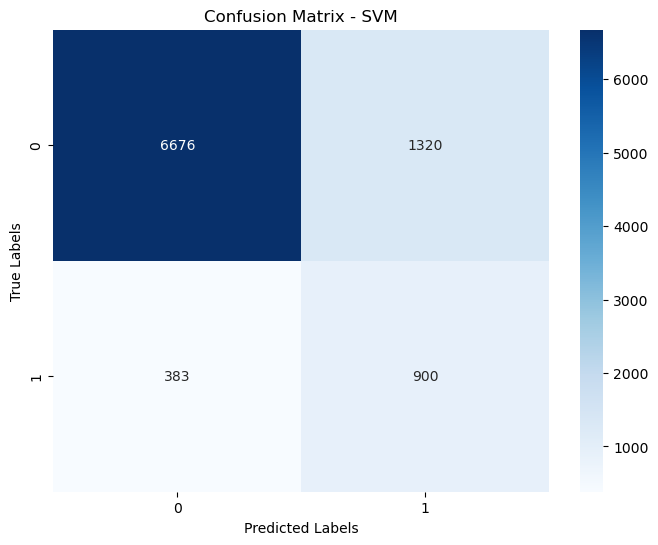

In [140]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt=".0f", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - SVM")
plt.show()

In [141]:
from sklearn.metrics import roc_auc_score

svm_pd=svm_predictions.select("label", "rawPrediction").toPandas()
svm_pd["score"]=svm_pd["rawPrediction"].apply(lambda x: x[1])

y_true=svm_pd["label"]
y_scores=svm_pd["score"]

fpr, tpr, thresholds=roc_curve(y_true, y_scores)

roc_auc=roc_auc_score(y_true, y_scores)
print(f"ROC AUC: {roc_auc:.2f}")

ROC AUC: 0.83


ROC curve

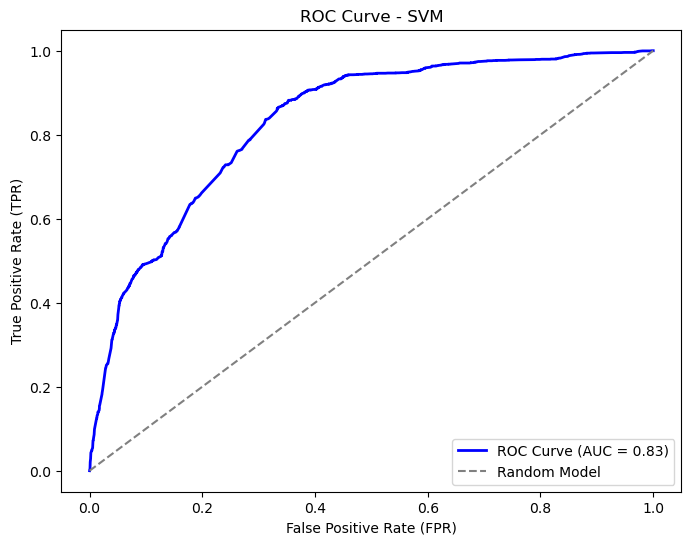

In [142]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Model")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve - SVM")
plt.legend(loc="lower right")
plt.show()

In [143]:
coefficients=svm_model.coefficients.toArray()

feature_names=train_df.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]
feature_names=[attr["name"] for attr in feature_names]

coefficients_df=pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})
coefficients_df["abs_coefficient"]=coefficients_df["Coefficient"].abs()
coefficients_df=coefficients_df.sort_values(by="abs_coefficient", ascending=False)
coefficients_df=coefficients_df.drop("abs_coefficient", axis=1)

feature importances

/var/folders/cj/0kgtzv813nq7ln3yhf7ms5n40000gn/T/ipykernel_43619/3124346854.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coefficients_df, x="Coefficient", y="Feature", palette="viridis")


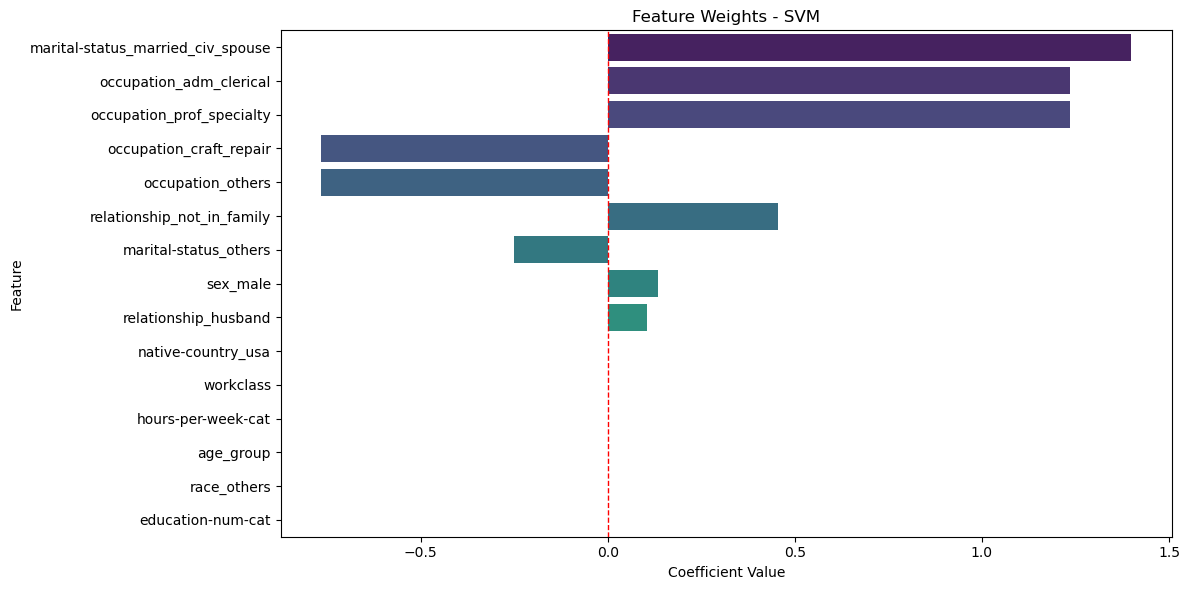

In [144]:
plt.figure(figsize=(12, 6))
sns.barplot(data=coefficients_df, x="Coefficient", y="Feature", palette="viridis")
plt.title("Feature Weights - SVM")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.axvline(0, color="red", linestyle="--", linewidth=1)
plt.tight_layout()
plt.show()

precision recall curve

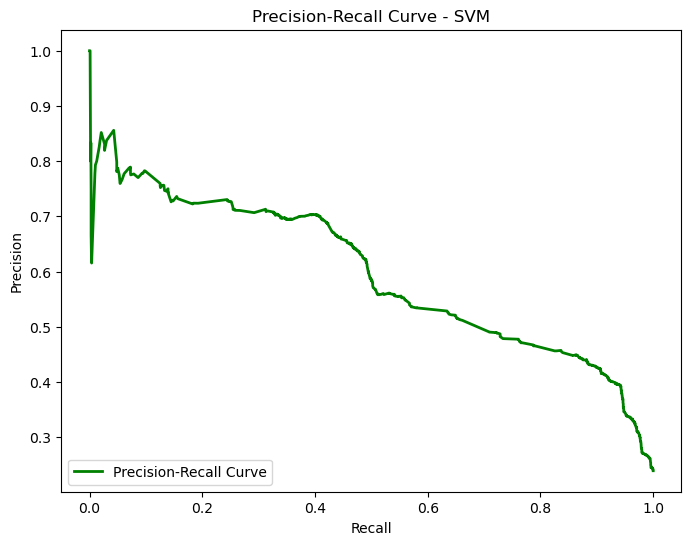

In [145]:
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color="green", lw=2, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - SVM")
plt.legend(loc="lower left")
plt.show()

In [146]:
spark.stop()